This notebook follows the example given in "Robust and Adaptive Control with Aerospace Applications" by Eugene Lavretsky and Kevin Wise. This example is found in Chapter 9, Example 9.3 and is MRAC control of delta wing dynamics at high angles of attack.

# MRAC Overview

MRAC is a cool control algorithm that takes into account uncertainty in the system and is able to estimate dynamic parameters real time when things either change during flight or are unknown. (example of quadrotor rotor getting clipped https://www.youtube.com/watch?v=2GkDGpCSDbU)

Assume you are given a MIMO system of the form

$$ \dot{x} = Ax + B \Lambda(u + f(x)) $$

where $x \in R^n$ is the system state, $u \in R^m$ is the control input, $B \in R^{n \times m}$ is the *known* control matrix, while $A \in R^{n \times n}$ and $\Lambda \in R^{m \times m}$ are unknown constant matrices. We also assume that $\Lambda$ is diagonal and all of its elements are strictly positive and $(A, B \Lambda)$ is controllable.

$f(x)$ is a possibly nonlinear vector-valued function representing the matched system uncertainty (i.e. where the uncertainty enters the system with the control input). We assume that this uncertainty can be written as a linear combination of locally Lipshitz-continuous basis functions $\varphi_i(x)$ (i.e. functions that are limited in how fast they can change). In other words,

$$
f(x) = \Theta^T \Phi(x)
$$

where $\Theta \in R^{N \times m}$ is a constant matrix of unknown coefficients and $\Phi(x) = [\varphi_1(x), \ldots, \varphi_N(x)]^T \in R^N$ is a *known* vector called the regressor.

At the end of the day, we want to design a MIMO state feedback controller that causes the system state $x$ to globally uniformly asympotically track a reference state $x_{ref} \in R^n$ of a reference model.

After some algebra and Lyapunov stability analysis shown in section 9.5 of the book, we get the following MRAC design equations:

Open-loop plant:

$$\dot{x}=A x+B \Lambda \left(u+\Theta^{T} \Phi(x)\right)$$

Reference Model:

$$ \dot{x}_{ref} = A_{ref} x_{ref} + B_{ref} r $$

Model matching conditions:

$$\quad A+B \Lambda K_{x}^{T}=A_{ref}, \quad B \Lambda K_{r}^{T}=B_{ref}$$

Tracking error:

$$e=x-x_{r e f}$$

Control input:

$$\quad u=\hat{K}_{x}^{T} x+\hat{K}_{r}^{T} r-\hat{\Theta}^{T} \Phi(x)$$

Algebraic Lyapunov equation:

$$\quad P A_{r e f}+A_{r e f}^{T} P=-Q$$

MIMO MRAC laws:

$$
\begin{aligned}
\dot{\hat{K}}_{x} &=-\Gamma_{x} x e^{T} P B \\
\dot{\hat{K}}_{r} &=-\Gamma_{r} r(t) e^{T} P B \\
\dot{\hat{\Theta}} &=\Gamma_{\Theta} \Phi(x) e^{T} P B
\end{aligned}
$$

# Dynamic Model

The generic roll dynamics are of the form:

$$
\begin{align}
\dot{\varphi} &= p\\
\dot{p} &= \theta_1 \varphi + \theta_2 p + (\theta_3 |\varphi| + \theta_4 |p|)p + \theta_5 \varphi^3 + \theta_6 \delta_a
\end{align}
$$

where $\varphi$ (rad) is the roll angle, $p$ is the roll rate (rad/s) and $\delta_a$ is the aileron differential (rad). The unknown constant parameters of this model are:

$$
\begin{align}
\theta_1 &= -0.018\\
\theta_2 &= 0.015\\
\theta_3 &= -0.062\\
\theta_4 &= 0.009\\
\theta_5 &= 0.021\\
\theta_6 &= 0.75\\
\end{align}
$$

Putting everything into the proper form we get:

$$
\underbrace{\left(\begin{array}{l}
\dot{\varphi} \\
\dot{p}
\end{array}\right)}_{x}=\underbrace{\left(\begin{array}{cc}
0 & 1 \\
\theta_{1} & \theta_{2}
\end{array}\right)}_{A} \underbrace{\left(\begin{array}{c}
\varphi \\
p
\end{array}\right)}_{x}+\underbrace{\left(\begin{array}{c}
0 \\
1
\end{array}\right)}_{B} \underbrace{\theta_{6}}_{\Lambda}\bigg(\underbrace{\delta_{a}}_{u}+\underbrace{\frac{1}{\theta_{6}}\left(\left(\theta_{3}|\varphi|+\theta_{4} |p|\right) p-\theta_{5} \varphi^{3}\right)}_{f(x)=\Theta^{T} \Phi(x)}\bigg)
$$

where

$$
\begin{aligned}
f(x) &=\underbrace{\frac{1}{\theta_{6}}\left(\theta_{3} \quad \theta_{4} \quad \theta_{5}\right)}_{\Theta^{T}} \underbrace{\left(|\varphi| p \quad |p| p \quad \varphi^{3}\right)^{T}}_{\Phi(x)} \\
&=-0.0827|\varphi| p+0.012|p| p+0.028 \varphi^{3}.
\end{aligned}
$$







# Reference Model

The reference model can really be anything we want it to be, as long as it can be put into state space form and it is of the same order ($n$) as the plant we are trying to control. A trick that we have used is to use $n$ first order systems for a reference system instead of an actual first order system.

The transfer function of a generic 2nd order system is

$$
\frac{\varphi_{ref}}{\varphi_{cmd}} = \frac{\omega_n^2}{s^2 + 2\zeta \omega_n^2 s + \omega_n^2}
$$

where $\varphi$ is the roll angle and we get to pick the desired natural frequency and damping ratio.

Converting the transfer function above results in the reference model in state space form (I should probably make sure I can actually do this by myself):

$$
\underbrace{\left(\begin{array}{l}
\dot{\varphi}_{\text {ref }} \\
\dot{p}_{\text {ref }}
\end{array}\right)}_{\dot{x}_{ref}}=\underbrace{\left(\begin{array}{cc}
0 & 1 \\
-\omega_{n}^{2} & -2 \xi \omega_{n}
\end{array}\right)}_{A_{ref}} \underbrace{\left(\begin{array}{c}
\varphi_{\text {ref }} \\
p_{\text {ref }}
\end{array}\right)}_{x_{\text {ref}}}+\underbrace{\left(\begin{array}{c}
0 \\
\omega_{n}^{2}
\end{array}\right)}_{B_{\text {ref}}} \underbrace{\varphi_{\text {cmd }}}_{r}
$$

By using the model matching conditions ($A+B \Lambda K_{x}^{T}=A_{ref}, \quad B \Lambda K_{r}^{T}=B_{ref}$) you can see that the ideal (note no hat) gains ($K_x^T$ and $K_r^T$) are:

$$K_x^T = -\frac{1}{\theta_6}(\omega_n^2 + \theta_1 \quad 2\zeta \omega_n + \theta_2), \quad K_r^T = \frac{\omega_n^2}{\theta_6}$$

In other words, these are the gain values which will cause the roll dynamics to track the reference model. Since we are in simulation land and already know the 'unknown constant parameters' ($\theta_{1-6}$), we can calculate the actual numerical values for the ideal gains above for a given damping ratio and natural freqency.

Earlier in the chapter, it mentions that the adaptive parameters do not always converge to their ideal values, but they are guaranteed to remain uniformly bounded.

Here is a diagram showing how the control structure is all connected:

![Control Diagram](https://drive.google.com/uc?id=1wRliYjvcvRaZUM33MdWc4CdLhR3itr00)

# Algorithm

The general control algorithm is as follows:


```
Initialize adaptive terms (to something): K_x_hat, K_r_hat, theta_hat
Initialize tuning params: lambda_x, lambda_r, lambda_theta, Q
Solve for P in algebraic Lyapunov equation.

Given reference command:
1. forward simulate reference model one time step --> x_ref
2. calculate control input (u) in controller block --> u
3. forward simulate plant with input (u) --> x
4. calculate error (x_ref - x) --> e
5. forward simulate adaptive law block to update gains --> K_x_hat, K_r_hat, theta_hat
```




# Simulation Setup

In [1]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00


In [2]:
# TO SHOW INTERACTIVE PLOT
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

In [162]:
import numpy as np
from scipy.integrate import solve_ivp
import scipy as sp
import time

# define tuning params, using ones from example
Gamma_x = np.diag([100,100]) #learning rate for Kx_hat
Gamma_r = 100 #learning rate for Kr_hat
Gamma_th = np.diag([100,100,100]) #learning rate for Theta_hat
Q = np.diag([1,10]) # Vdot = -e.T @ Q @ e for lyapunov stability on tracking.

# define systems and parameters globally
# real parameters of the system
theta1 = -.018
theta2 = .015
theta3 = -.062
theta4 = .009
theta5 = .021
theta6 = .75

#state space formulation
A = np.array([[0,1],[theta1, theta2]])
B = np.array([0,1])

#desired second order system params, book has 1 and 0.7 for cmd in book
wn = 1
zeta = .7

# state space reference system
A_ref = np.array([[0,1],[-wn**2, -2*zeta*wn]])
B_ref = np.array([0, wn**2])

# solution to algebraic lyapunov equation, but pass in A.T and -Q to fit scipy docs
P = sp.linalg.solve_continuous_lyapunov(A_ref.T, -Q)
print('P (should be PD and symmetric): \n', P)

#ideal gains for testing
ideal_adapt = np.array([-1.3093, -1.8867, 1.3333, -0.062, .009, .021])


def calc_plant_derivs(state, input):
  """
  Note that these actual values are generally unknown, but exist in the plant.
  We assume they are known here for simulation. On hardware, the estimates of these parameters are bounded
  and will converge to something, not necessarily the true plant parameters

  state = [varphi, p].T
  input = delta_a (differential aileron (rad))
  """

  #make sure things are the right sizes
  assert(state.shape==(2,))
  assert(np.isscalar(input))

  varphi = state[0]
  p = state[1]

  # print('x: ', np.degrees(state))
  # print('u: ', np.degrees(input), '\n')

  # time.sleep(0.1)


  #calculate xdot
  xdot = A @ state + B * theta6 * (input + -.0827*np.abs(varphi)*p + .012*np.abs(p)*p +.028*varphi**3)

  #rate constraint
#   max = np.array([0.1,0.1])
#   xdot = np.clip(xdot, -max, max)

  return xdot

def calc_ref_derivs(ref_state, input):
  '''
  ref_state = [varphi_ref, p_ref].T
  input = varphi_cmd
  '''
  #make sure things are the right sizes
  assert(ref_state.shape==(2,))
  assert(np.isscalar(input))

  ref_dot = A_ref @ ref_state + B_ref * input

  return ref_dot

def calc_adapt_derivs(adapt_state, input):
  '''
  adapt state = [K_x_hat, K_r_hat, theta_hat].T
  input = [e, x, r], python list, error is a vector, x is a vector, r is a scalar
  '''

  e = input[0]
  x = input[1]
  r = input[2]

  # print('e', e)
  # print('x', x)
#   print('r', r)

  #make sure things are the right sizes
  assert(adapt_state.shape==(2+1+3,))
  assert(e.shape==(2,))
  assert(x.shape==(2,))
  assert(np.isscalar(r))

  # note reshaping so that x@x.T returns matrix, not a scalar
  K_x_hat_dot = -Gamma_x @ x.reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 2x2 2x1 1x2 2x2 2x1 = 2x1
  K_r_hat_dot = -Gamma_r * r * e.reshape(-1,1).T @ P @ B # 1x2 2x2 2x1 = scalar
  Theta_hat_dot = Gamma_th @ calc_Phi(x).reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 3x3 3x1 1x2 2x2 2x1 = 3x1

  return np.concatenate((K_x_hat_dot, K_r_hat_dot, Theta_hat_dot))

def calc_all_derivs(t, augmented_state):
    plant_state = augmented_state[:2] #2
    ref_state = augmented_state[2:4] #2
    # adapt_state = augmented_state[4:] #6

    adapt_state = np.array(
    [
        -(wn**2+theta1)/theta6,
        -(2*zeta*wn + theta2)/theta6,
        wn**2/theta6,
        theta3/theta6,
        theta4/theta6,
        theta5/theta6
     ]
    )

    freq = 1/30
    r = np.radians(15) * (np.sin(2*np.pi*freq*t) + np.sin(2*np.pi* freq/2*t) + np.sin(2*np.pi*freq*2*t))
    u = calc_control_input(adapt_state, r, plant_state)
    e = plant_state - ref_state


    plant_dot = calc_plant_derivs(plant_state, u)
    ref_dot = calc_ref_derivs(ref_state, r)
    adapt_input = [e, plant_state, r]
    adapt_dot = calc_adapt_derivs(adapt_state, adapt_input) * 0

    derivs = np.hstack([plant_dot, ref_dot, adapt_dot])

    return derivs


def forward_sim_dt(x, u, dt, deriv_func):
#   u is a zero order hold
  F1 = deriv_func(x, u)
  F2 = deriv_func(x + dt/2 * F1, u)
  F3 = deriv_func(x + dt/2 * F2, u)
  F4 = deriv_func(x + dt * F3, u)
  x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

  #but u can't be zero order hold, because it is state dependent, and the state itself is changing.

#   x += deriv_func(x,u) * dt

  return x

def calc_control_input(adapt, ref, state):
  Kx_hat = adapt[:2]
  Kr_hat = adapt[2]
  Theta_hat = adapt[3:]

  # 1x2 2x1 + 1x1 1x1 - 1x3 3x1 = 1x1
#   u = Kx_hat.T @ state + Kr_hat.T * ref - Theta_hat.T @ calc_Phi(state)
  u = Kx_hat.T @ state + Kr_hat.T * ref - (1/theta6) * np.array([theta3, theta4, theta5]).T @ calc_Phi(state)

  return u


def calc_Phi(state):
  #make sure things are the right sizes
  assert(state.shape==(2,))

  varphi = state[0]
  p = state[1]

  Phi = np.array([np.abs(varphi)*p, np.abs(p)*p, varphi**3])

  return Phi




P (should be PD and symmetric): 
 [[4.62857143 0.5       ]
 [0.5        3.92857143]]


# Simulation

In [111]:
from tqdm import tqdm
# simulation times
dt = .01
tspan = np.arange(0,60*5,dt)

# generate reference trajectory
from scipy import signal
freq = 1/30
# ref_traj = np.radians(15) * signal.square(2 * np.pi * freq * tspan)
ref_traj = np.radians(15) * (np.sin(2*np.pi*freq*tspan) + np.sin(2*np.pi* freq/2*tspan) + np.sin(2*np.pi*freq*2*tspan))



# make lists for history keeping
x_hist = []
xref_hist = []
u_hist = []
error_hist = []
adapt_params_hist = []

# initial conditions
x = np.array([0.0,0.0])
x_ref = np.array([0.0,0.0])
adapt_params = np.zeros(6)
# kx (2), Kr (1), theta(3), from book and model matching conditions
true_adapt_params = np.array(
    [
        -(wn**2+theta1)/theta6,
        -(2*zeta*wn + theta2)/theta6,
        wn**2/theta6,
        theta3/theta6,
        theta4/theta6,
        theta5/theta6
     ]
)

# simulation loop
for i in tqdm(range(len(tspan))):
  # get current ref input
  ref = ref_traj[i]

  # calculate error
  error = x - x_ref

  # calculate control input
  u = calc_control_input(true_adapt_params, ref, x)

  #simulate input saturation, pretend aileron can only deflect to 20 degrees
#   u = np.clip(u, -np.radians(20), np.radians(20))

  # save states[t] to list
  x_hist.append(x.copy())
  xref_hist.append(x_ref.copy())
  adapt_params_hist.append(adapt_params.copy())
  error_hist.append(error.copy())
  u_hist.append(u.copy())

  # forward sim ref system
  x_ref = forward_sim_dt(x_ref, ref, dt, calc_ref_derivs)
  # forward simulate plant
  x = forward_sim_dt(x, u, dt, calc_plant_derivs)

  # update adaptive params
#   if np.any(np.degrees(np.abs(error) > 1e-3)):
    # print("adapting")
  adaptive_input = [error, x, ref]
  adapt_params = forward_sim_dt(adapt_params, adaptive_input, dt, calc_adapt_derivs)

#   # add output disturbance
#   if i > 2000 and i < 2500:
#       x = x+.01



# convert list to np arrays for plotting.
xref_hist = np.array(xref_hist)
x_hist = np.array(x_hist)
u_hist = np.array(u_hist)
adapt_params_hist = np.array(adapt_params_hist)
error_hist = np.array(error_hist)

100%|██████████| 30000/30000 [00:10<00:00, 2845.44it/s]


In [163]:
from scipy.integrate import solve_ivp

sol = solve_ivp(calc_all_derivs, (tspan[0], tspan[-1]), t_eval=tspan, y0=np.zeros(10), max_step=.01)

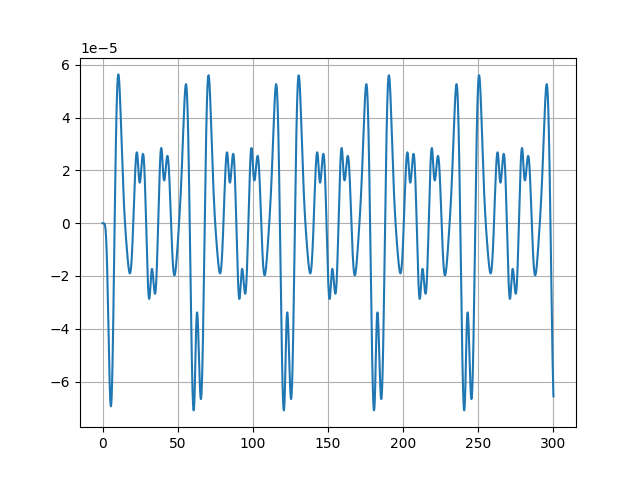

In [164]:
#plot the sol from solve_ivp
error = sol.y[0] - sol.y[2]
plt.figure()
plt.plot(tspan, np.degrees(error))
plt.grid(True)



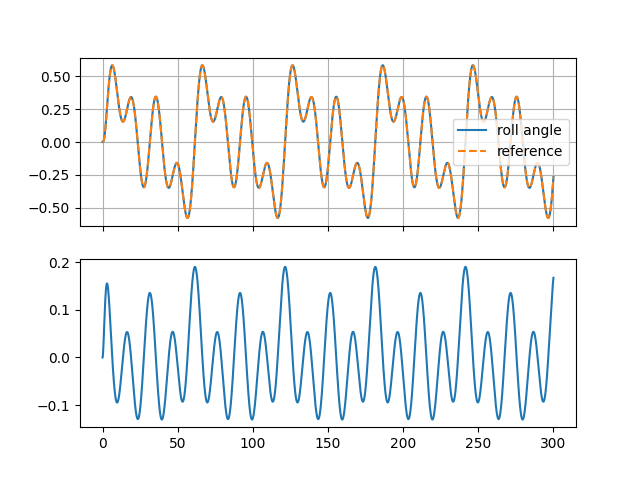

In [165]:
fig,axs = plt.subplots(2,1, sharex=True)
axs[0].plot(tspan, sol.y[0])
axs[0].plot(tspan, sol.y[2], '--')
axs[0].grid(True)
axs[0].legend(['roll angle', 'reference'])
axs[1].plot(tspan, sol.y[1])

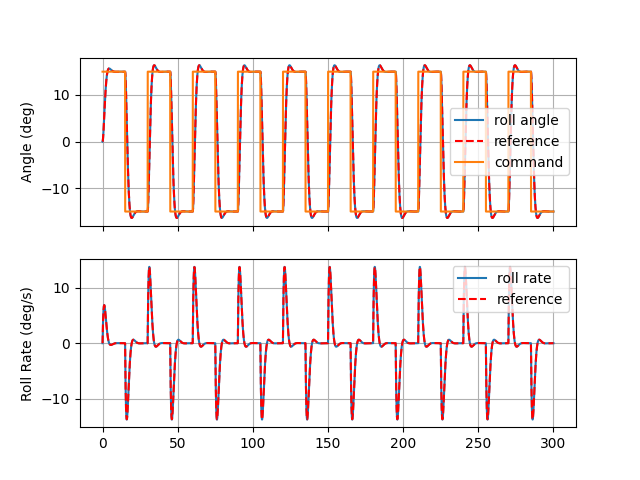

In [106]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,1, sharex=True)

axs[0].plot(tspan, np.degrees(x_hist[:,0]))
axs[0].plot(tspan, np.degrees(xref_hist[:,0]), '--r')
axs[0].plot(tspan, np.degrees(ref_traj))
axs[0].grid(True)
axs[0].legend(['roll angle', 'reference', 'command'])
axs[0].set_ylabel('Angle (deg)')

axs[1].plot(tspan, np.degrees(x_hist[:,1]))
axs[1].plot(tspan, np.degrees(xref_hist[:,1]), '--r')
axs[1].grid(True)
axs[1].set_ylabel('Roll Rate (deg/s)')
axs[1].legend(['roll rate', 'reference', 'command'])


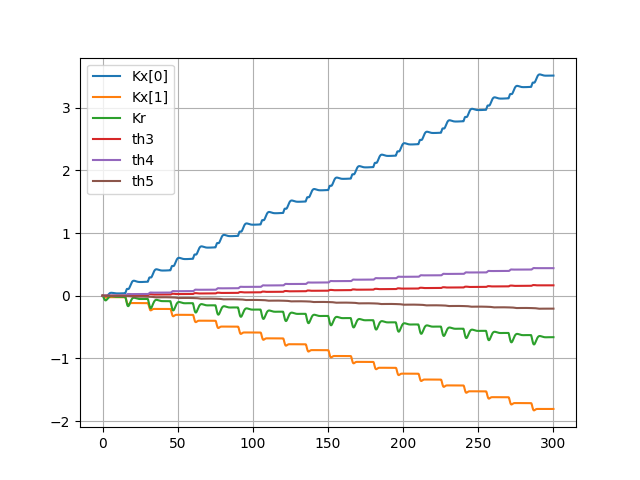

In [107]:
plt.figure()
plt.plot(tspan, adapt_params_hist)
plt.legend(['Kx[0]', 'Kx[1]', 'Kr', 'th3', 'th4', 'th5'])
plt.grid(True)

# Extra Plots

Text(0, 0.5, 'Roll Angle Tracking Error (deg)')

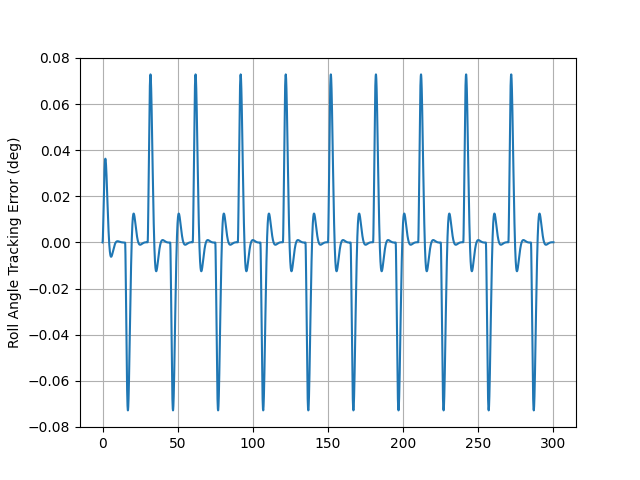

In [108]:
plt.figure()
plt.plot(tspan, np.degrees(error_hist[:,0]))
plt.grid(True)
plt.ylabel('Roll Angle Tracking Error (deg)')

Text(0, 0.5, 'Roll Rate Error (deg)')

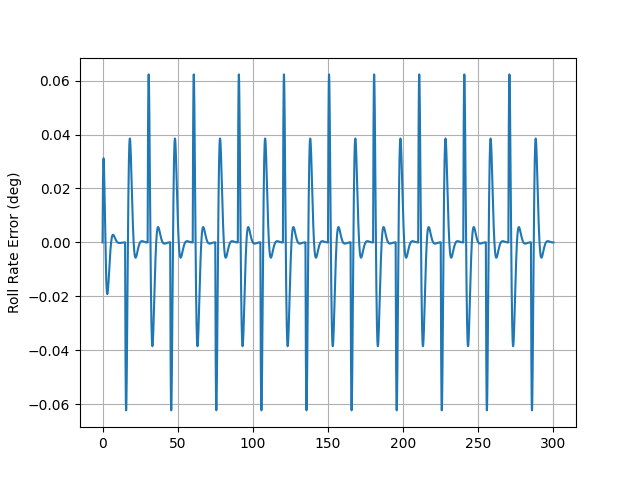

In [109]:
plt.figure()
plt.plot(tspan, np.degrees(error_hist[:,1]))
plt.grid(True)
plt.ylabel('Roll Rate Error (deg)')

Text(0, 0.5, 'Aileron Deflection (deg)')

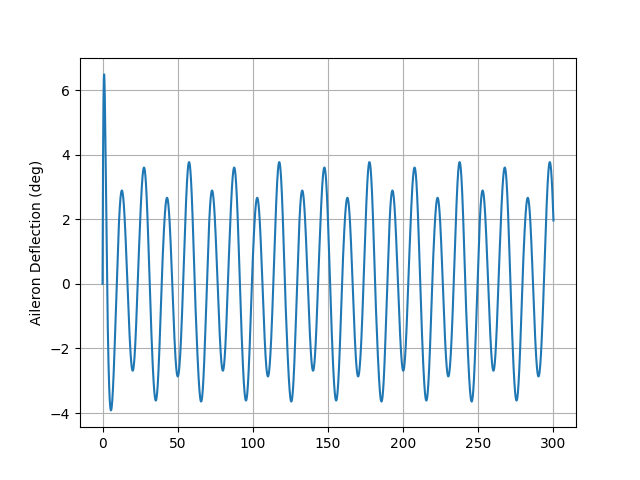

In [77]:
plt.figure()
plt.plot(tspan, np.degrees(u_hist))
plt.grid(True)
plt.ylabel('Aileron Deflection (deg)')

# Tuning Process



1.   Tune reference system to be able to track the given desired trajectory.
2.   Q is a knob to adjust how 'fast' the system converges to the reference system.
3.   The other gains control learning rates for adaptive parameters. Change them around based on the convergence of each parameter.


# Using Radial Basis Functions

Override functions above to use RBFs instead.

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import scipy as sp
import time

N = 50
centers = np.random.uniform(-10, 10, (N, 2)) #9 2D centers
dMax = np.linalg.norm(centers[1, :] - centers[0, :])
width = N / dMax**2

Gamma_th = np.diag([50]*(N+1)) #learning rate for Theta_hat

def calc_plant_derivs(state, input):
  """
  Note that these actual values are generally unknown, but exist in the plant.
  We assume they are known here for simulation. On hardware, the estimates of these parameters are bounded
  and will converge to something, not necessarily the true plant parameters

  state = [varphi, p].T
  input = delta_a (differential aileron (rad))
  """

  #make sure things are the right sizes
  assert(state.shape==(2,))
  assert(np.isscalar(input))

  varphi = state[0]
  p = state[1]

  # print('x: ', np.degrees(state))
  # print('u: ', np.degrees(input), '\n')

  # time.sleep(0.1)


  #calculate xdot
  xdot = A @ state + B * theta6 * (input + -.0827*np.abs(varphi)*p + .012*np.abs(p)*p +.028*varphi**3)

  #rate constraint
#   max = np.array([0.1,0.1])
#   xdot = np.clip(xdot, -max, max)

  return xdot

def calc_ref_derivs(ref_state, input):
  '''
  ref_state = [varphi_ref, p_ref].T
  input = varphi_cmd
  '''
  #make sure things are the right sizes
  assert(ref_state.shape==(2,))
  assert(np.isscalar(input))

  ref_dot = A_ref @ ref_state + B_ref * input

  return ref_dot

def calc_adapt_derivs(adapt_state, input):
  '''
  adapt state = [K_x_hat, K_r_hat, theta_hat].T
  input = [e, x, r], python list, error is a vector, x is a vector, r is a scalar
  '''

  e = input[0]
  x = input[1]
  r = input[2]

  # print('e', e)
  # print('x', x)
  # print('r', r)

  #make sure things are the right sizes
  assert(adapt_state.shape==(N+1+3,))
  assert(e.shape==(2,))
  assert(x.shape==(2,))
  assert(np.isscalar(r))

  # note reshaping so that x@x.T returns matrix, not a scalar
  K_x_hat_dot = -Gamma_x @ x.reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 2x2 2x1 1x2 2x2 2x1 = 2x1
  K_r_hat_dot = -Gamma_r * r * e.reshape(-1,1).T @ P @ B # 1x2 2x2 2x1 = scalar
  Theta_hat_dot = Gamma_th @ calc_Phi(x).reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 3x3 3x1 1x2 2x2 2x1 = 3x1

  return np.concatenate((K_x_hat_dot, K_r_hat_dot, Theta_hat_dot))

def forward_sim_dt(x, u, dt, deriv_func):
  F1 = deriv_func(x, u)
  F2 = deriv_func(x + dt/2 * F1, u)
  F3 = deriv_func(x + dt/2 * F2, u)
  F4 = deriv_func(x + dt * F3, u)
  x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

  return x

def calc_control_input(adapt, ref, state):
  Kx_hat = adapt[:2]
  Kr_hat = adapt[2]
  Theta_hat = adapt[3:]

  phi = calc_Phi(state)

  # 1x2 2x1 + 1x1 1x1 - 1x3 3x1 = 1x1
  u = Kx_hat.T @ state + Kr_hat.T * ref - Theta_hat.T @ phi

  return u


def calc_Phi(state):
    norms = np.linalg.norm(state - centers, axis=1)
    Phi = np.exp(-width * norms**2)

    return np.append(Phi, 1.0)




In [ ]:
# make lists for history keeping
x_hist = []
xref_hist = []
u_hist = []
error_hist = []
adapt_params_hist = []

# initial conditions
x = np.array([0.1,0.1])
x_ref = np.array([0.0,0.0])
adapt_k = np.zeros(3)
Theta = np.random.uniform(-1,1, (N+1,)) #number of RBFs x num inputs, weights
# W = np.random.unifro
adapt_params = np.hstack([adapt_k, Theta])

# simulation loop
for i in tqdm(range(len(tspan))):
#   adapt_params = np.clip(adapt_params,-1,1)
  # print(tspan[i])
  # save states to list
  x_hist.append(x.copy())
  xref_hist.append(x_ref.copy())
  adapt_params_hist.append(adapt_params.copy())

  # get current ref input
  ref = ref_traj[i]

  # forward sim ref system
  x_ref = forward_sim_dt(x_ref, ref, dt, calc_ref_derivs)

  # calculate control input
  u = calc_control_input(adapt_params, ref, x)

  #simulate input saturation, pretend aileron can only deflect to 20 degrees
#   u = np.clip(u, -np.radians(20), np.radians(20))

  u_hist.append(u.copy())

  # forward simulate plant
  x = forward_sim_dt(x, u, dt, calc_plant_derivs)

#   # add output disturbance
#   if i > 2000 and i < 2500:
#       x = x+.01

  # calculate error
  error = x - x_ref
  error_hist.append(error.copy())

  # update adaptive params
  adaptive_input = [error, x, ref]
  adapt_params = forward_sim_dt(adapt_params, adaptive_input, dt, calc_adapt_derivs)

# convert list to np arrays for plotting.
xref_hist = np.array(xref_hist)
x_hist = np.array(x_hist)
u_hist = np.array(u_hist)
adapt_params_hist = np.array(adapt_params_hist)
error_hist = np.array(error_hist)

100%|██████████| 30000/30000 [00:12<00:00, 2323.97it/s]


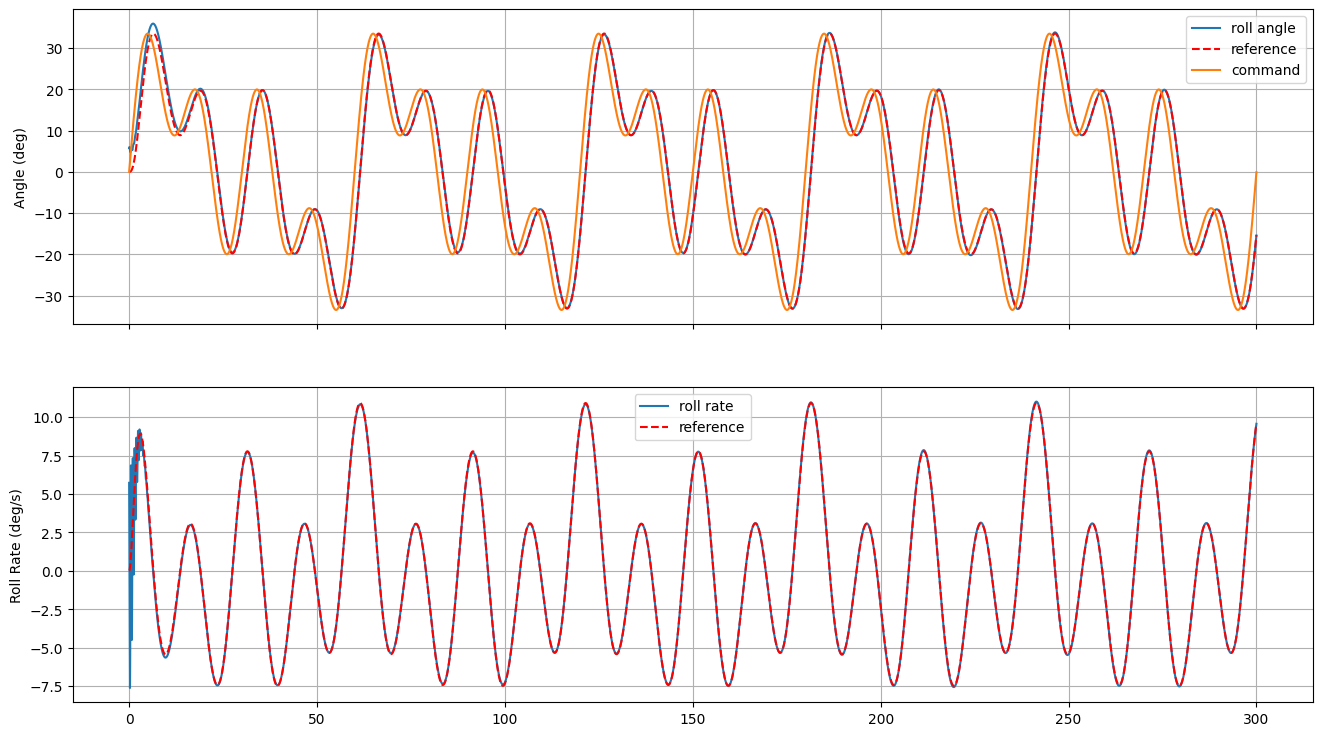

In [ ]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,1, sharex=True, figsize=(16,9))

axs[0].plot(tspan, np.degrees(x_hist[:,0]))
axs[0].plot(tspan, np.degrees(xref_hist[:,0]), '--r')
axs[0].plot(tspan, np.degrees(ref_traj))
axs[0].grid(True)
axs[0].legend(['roll angle', 'reference', 'command'])
axs[0].set_ylabel('Angle (deg)')

axs[1].plot(tspan, np.degrees(x_hist[:,1]))
axs[1].plot(tspan, np.degrees(xref_hist[:,1]), '--r')
axs[1].grid(True)
axs[1].set_ylabel('Roll Rate (deg/s)')
axs[1].legend(['roll rate', 'reference', 'command'])

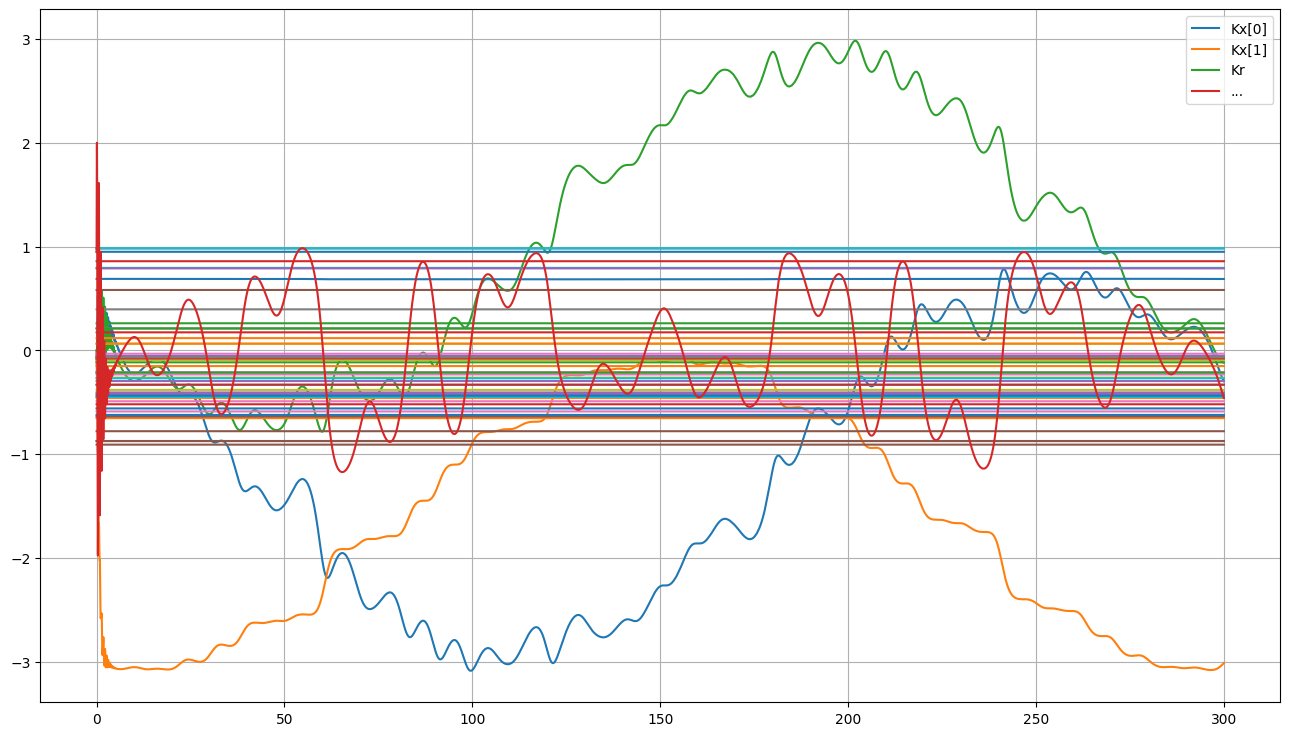

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(tspan, adapt_params_hist)
plt.legend(['Kx[0]', 'Kx[1]', 'Kr','...'])
plt.grid(True)

Text(0, 0.5, 'Roll Tracking Error (deg)')

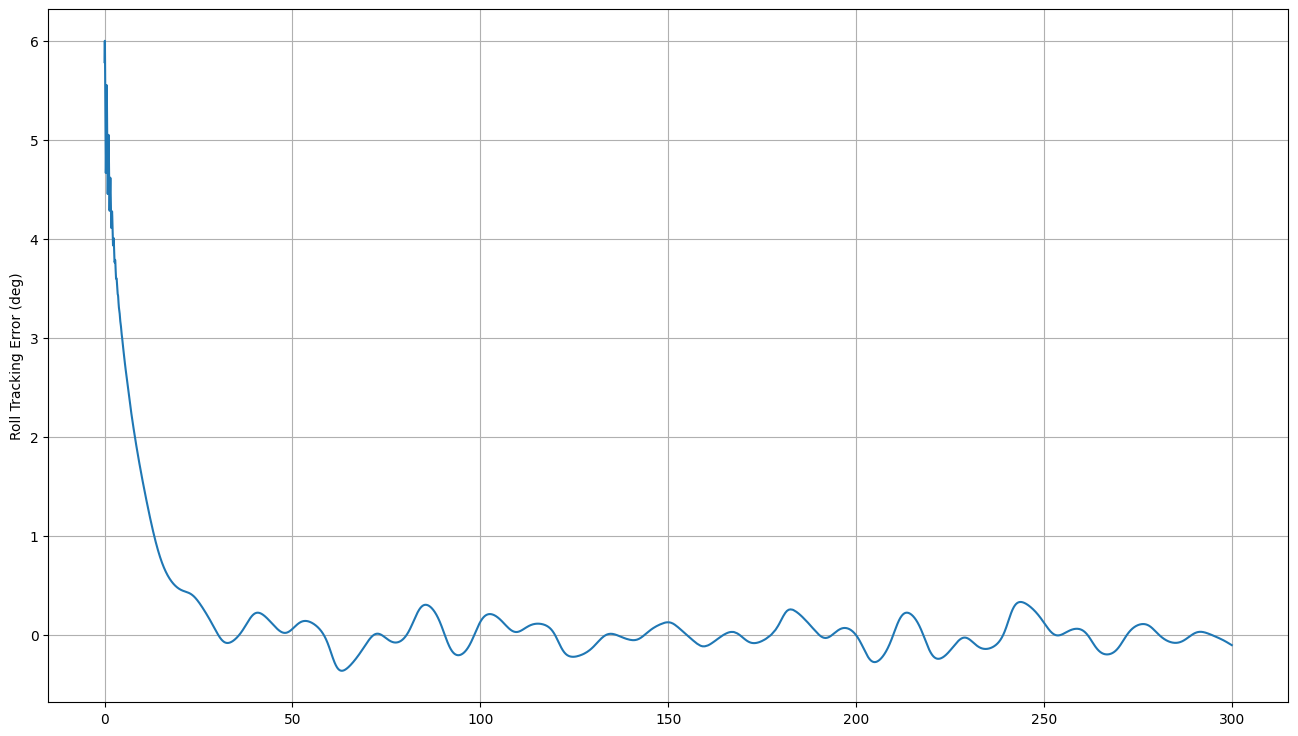

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(tspan, np.degrees(error_hist[:,0]))
plt.grid(True)
plt.ylabel('Roll Tracking Error (deg)')

# Autotuner Results

In [ ]:
# define tuning params, using ones from example
Gamma_x = np.diag([study.best_params['Gamma_x1'],study.best_params['Gamma_x2']]) #learning rate for Kx_hat
Gamma_r = study.best_params['Gamma_r'] #learning rate for Kr_hat
Gamma_th = np.diag([study.best_params['Gamma_th1'],study.best_params['Gamma_th2'],study.best_params['Gamma_th3']]) #learning rate for Theta_hat
Q = np.diag([study.best_params['Q1'],study.best_params['Q2']]) # Vdot = -e.T @ Q @ e for lyapunov stability on tracking.

# define systems and parameters globally
# real parameters of the system
theta1 = -.018
theta2 = .015
theta3 = -.062
theta4 = .009
theta5 = .021
theta6 = .75

#state space formulation
A = np.array([[0,1],[theta1, theta2]])
B = np.array([0,1])

#desired second order system params, book has 1 and 0.7 for cmd in book
wn = 1
zeta = 0.7

# state space reference system
A_ref = np.array([[0,1],[-wn**2, -2*zeta*wn]])
B_ref = np.array([0, wn**2])

# solution to algebraic lyapunov equation, but pass in A.T and -Q to fit scipy docs
P = sp.linalg.solve_continuous_lyapunov(A_ref.T, -Q)
print('P (should be PD and symmetric): \n', P)

#ideal gains for testing
ideal_adapt = np.array([-1.3093, -1.8867, 1.3333, -0.062, .009, .021])


def calc_plant_derivs(state, input):
  """
  Note that these actual values are generally unknown, but exist in the plant.
  We assume they are known here for simulation. On hardware, the estimates of these parameters are bounded
  and will converge to something, not necessarily the true plant parameters

  state = [varphi, p].T
  input = delta_a (differential aileron (rad))
  """

  #make sure things are the right sizes
  assert(state.shape==(2,))
  assert(np.isscalar(input))

  varphi = state[0]
  p = state[1]

  # print('x: ', np.degrees(state))
  # print('u: ', np.degrees(input), '\n')

  # time.sleep(0.1)


  #calculate xdot
  xdot = A @ state + B * theta6 * (input + -.0827*np.abs(varphi)*p + .012*np.abs(p)*p +.028*varphi**3)

  return xdot

def calc_ref_derivs(ref_state, input):
  '''
  ref_state = [varphi_ref, p_ref].T
  input = varphi_cmd
  '''
  #make sure things are the right sizes
  assert(ref_state.shape==(2,))
  assert(np.isscalar(input))

  ref_dot = A_ref @ ref_state + B_ref * input

  return ref_dot

def calc_adapt_derivs(adapt_state, input):
  '''
  adapt state = [K_x_hat, K_r_hat, theta_hat].T
  input = [e, x, r], python list, error is a vector, x is a vector, r is a scalar
  '''

  e = input[0]
  x = input[1]
  r = input[2]

  # print('e', e)
  # print('x', x)
  # print('r', r)

  #make sure things are the right sizes
  assert(adapt_state.shape==(2+1+3,))
  assert(e.shape==(2,))
  assert(x.shape==(2,))
  assert(np.isscalar(r))

  # note reshaping so that x@x.T returns matrix, not a scalar
  K_x_hat_dot = -Gamma_x @ x.reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 2x2 2x1 1x2 2x2 2x1 = 2x1
  K_r_hat_dot = -Gamma_r * r * e.reshape(-1,1).T @ P @ B # 1x2 2x2 2x1 = scalar
  Theta_hat_dot = Gamma_th @ calc_Phi(x).reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 3x3 3x1 1x2 2x2 2x1 = 3x1

  return np.concatenate((K_x_hat_dot, K_r_hat_dot, Theta_hat_dot))

def forward_sim_dt(x, u, dt, deriv_func):
  F1 = deriv_func(x, u)
  F2 = deriv_func(x + dt/2 * F1, u)
  F3 = deriv_func(x + dt/2 * F2, u)
  F4 = deriv_func(x + dt * F3, u)
  x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

  return x

def calc_control_input(adapt, ref, state):
  Kx_hat = adapt[:2]
  Kr_hat = adapt[2]
  Theta_hat = adapt[3:]

  # 1x2 2x1 + 1x1 1x1 - 1x3 3x1 = 1x1
  u = Kx_hat.T @ state + Kr_hat.T * ref - Theta_hat.T @ calc_Phi(state)

  return u

def calc_Phi(state):
  #make sure things are the right sizes
  assert(state.shape==(2,))

  varphi = state[0]
  p = state[1]

  Phi = np.array([np.abs(varphi)*p, np.abs(p)*p, varphi**3])

  return Phi


P (should be PD and symmetric): 
 [[15.10626685  3.87987135]
 [ 3.87987135  9.67444697]]


In [ ]:
# simulation times
dt = .01
tspan = np.arange(0,120,dt)

# generate reference trajectory
from scipy import signal
freq = 1/20
ref_traj = np.radians(5) * signal.square(2 * np.pi * freq * tspan) + np.radians(5)

# make lists for history keeping
x_hist = []
xref_hist = []
u_hist = []
error_hist = []
adapt_params_hist = []

# initial conditions
x = np.array([0.1,0.1])
x_ref = np.array([0.0,0.0])
adapt_params = np.zeros(6)

# simulation loop
for i in range(len(tspan)):
  # print(tspan[i])
  # save states to list
  x_hist.append(x.copy())
  xref_hist.append(x_ref.copy())
  adapt_params_hist.append(adapt_params.copy())

  # get current ref input
  ref = ref_traj[i]

  # forward sim ref system
  x_ref = forward_sim_dt(x_ref, ref, dt, calc_ref_derivs)

  # calculate control input
  u = calc_control_input(adapt_params, ref, x)
  u_hist.append(u.copy())

  # forward simulate plant
  x = forward_sim_dt(x, u, dt, calc_plant_derivs)

  # calculate error
  error = x - x_ref
  error_hist.append(error.copy())

  # update adaptive params
  adaptive_input = [error, x, ref]
  adapt_params = forward_sim_dt(adapt_params, adaptive_input, dt, calc_adapt_derivs)

# convert list to np arrays for plotting.
xref_hist = np.array(xref_hist)
x_hist = np.array(x_hist)
u_hist = np.array(u_hist)
adapt_params_hist = np.array(adapt_params_hist)
error_hist = np.array(error_hist)

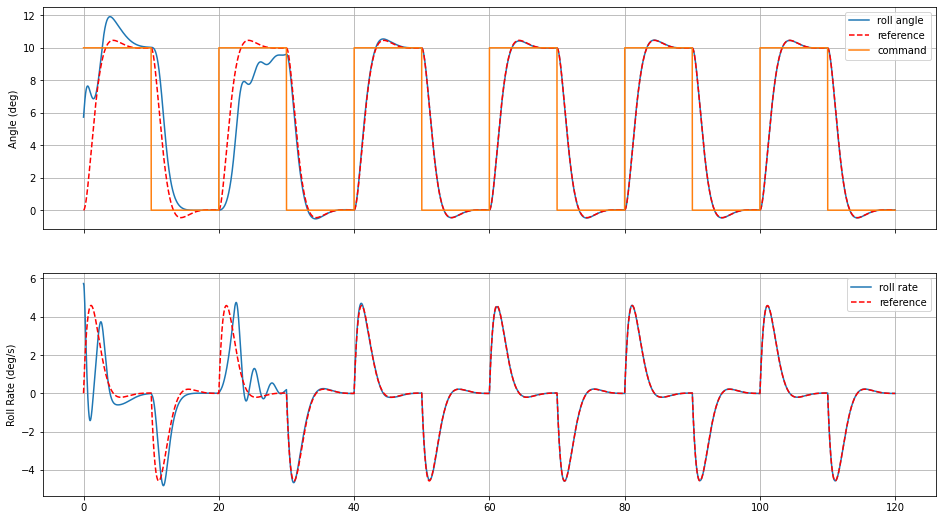

In [ ]:
fig,axs = plt.subplots(2,1, sharex=True, figsize=(16,9))

axs[0].plot(tspan, np.degrees(x_hist[:,0]))
axs[0].plot(tspan, np.degrees(xref_hist[:,0]), '--r')
axs[0].plot(tspan, np.degrees(ref_traj))
axs[0].grid(True)
axs[0].legend(['roll angle', 'reference', 'command'])
axs[0].set_ylabel('Angle (deg)')

axs[1].plot(tspan, np.degrees(x_hist[:,1]))
axs[1].plot(tspan, np.degrees(xref_hist[:,1]), '--r')
axs[1].grid(True)
axs[1].set_ylabel('Roll Rate (deg/s)')
axs[1].legend(['roll rate', 'reference', 'command'])

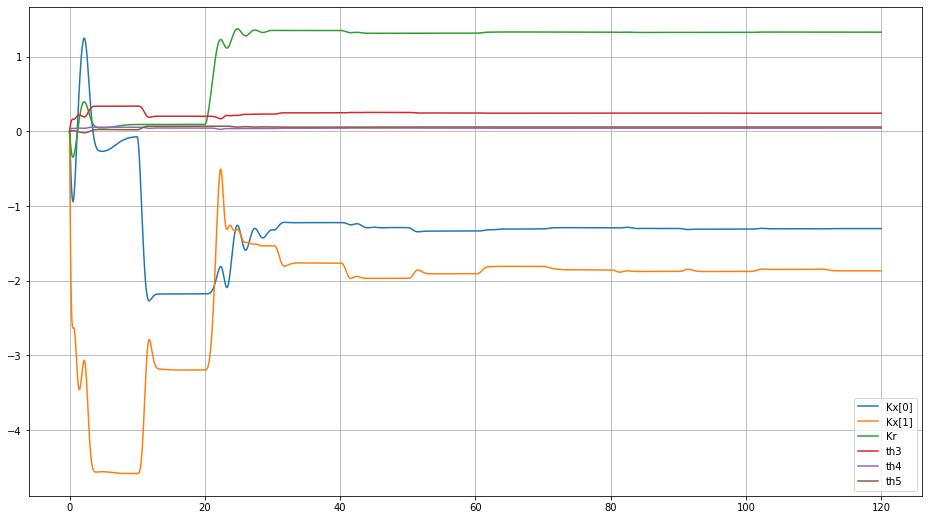

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(tspan, adapt_params_hist)
plt.legend(['Kx[0]', 'Kx[1]', 'Kr', 'th3', 'th4', 'th5'])
plt.grid(True)

Text(0, 0.5, 'Aileron Deflection (deg)')

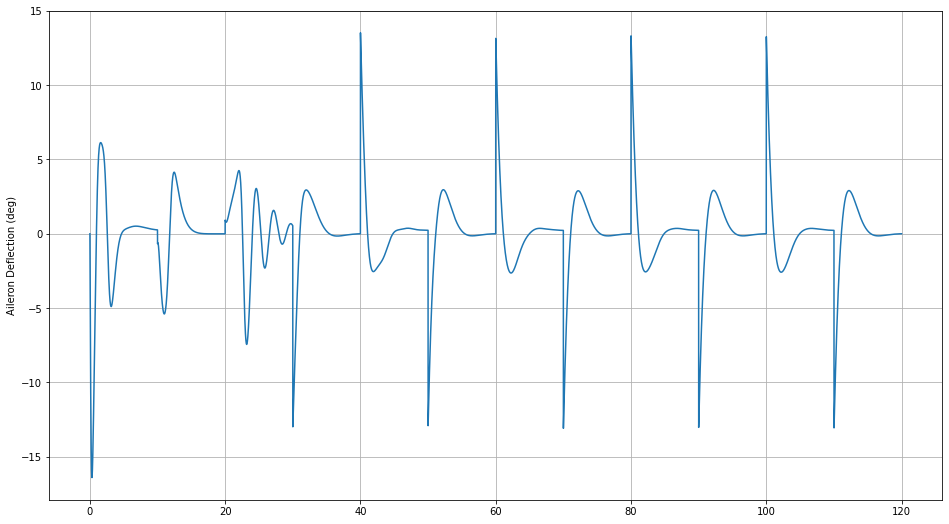

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(tspan, np.degrees(u_hist))
plt.grid(True)
plt.ylabel('Aileron Deflection (deg)')

# Automatic Tuning - Extras

In [ ]:
!pip3 install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
  # # define tuning params, using ones from example
  # Gamma_x = np.diag([1,1]) #learning rate for Kx_hat
  # Gamma_r = 1 #learning rate for Kr_hat
  # Gamma_th = np.diag([1,1,1]) #learning rate for Theta_hat
  # Q = np.diag([100,100]) # Vdot = -e.T @ Q @ e for lyapunov stability on tracking.

  Gamma_x1 = trial.suggest_loguniform("Gamma_x1", .1, 1000)
  Gamma_x2 = trial.suggest_loguniform("Gamma_x2", .1, 1000)
  Gamma_r = trial.suggest_loguniform("Gamma_r", .1, 1000)
  Gamma_th1 = trial.suggest_loguniform("Gamma_th1", .1, 1000)
  Gamma_th2 = trial.suggest_loguniform("Gamma_th2", .1, 1000)
  Gamma_th3 = trial.suggest_loguniform("Gamma_th3", .1, 1000)
  Q1 = trial.suggest_loguniform("Q1", .1, 1000)
  Q2 = trial.suggest_loguniform("Q2", .1, 1000)

  Gamma_x = np.diag([Gamma_x1,Gamma_x2]) #learning rate for Kx_hat
  Gamma_r =  Gamma_r #learning rate for Kr_hat
  Gamma_th = np.diag([Gamma_th1,Gamma_th2,Gamma_th3]) #learning rate for Theta_hat
  Q = np.diag([Q1,Q2]) # Vdot = -e.T @ Q @ e for lyapunov stability on tracking.

  # define systems and parameters globally
  # real parameters of the system
  theta1 = -.018
  theta2 = .015
  theta3 = -.062
  theta4 = .009
  theta5 = .021
  theta6 = .75

  #state space formulation
  A = np.array([[0,1],[theta1, theta2]])
  B = np.array([0,1])

  #desired second order system params, book has 1 and 0.7 for cmd in book
  wn = 1
  zeta = 0.7

  # state space reference system
  A_ref = np.array([[0,1],[-wn**2, -2*zeta*wn]])
  B_ref = np.array([0, wn**2])

  # solution to algebraic lyapunov equation, but pass in A.T and -Q to fit scipy docs
  P = sp.linalg.solve_continuous_lyapunov(A_ref.T, -Q)

  #ideal gains for testing
  ideal_adapt = np.array([-1.3093, -1.8867, 1.3333, -0.062, .009, .021])


  def calc_plant_derivs(state, input):
    """
    Note that these actual values are generally unknown, but exist in the plant.
    We assume they are known here for simulation. On hardware, the estimates of these parameters are bounded
    and will converge to something, not necessarily the true plant parameters

    state = [varphi, p].T
    input = delta_a (differential aileron (rad))
    """

    #make sure things are the right sizes
    assert(state.shape==(2,))
    assert(np.isscalar(input))

    varphi = state[0]
    p = state[1]

    # print('x: ', np.degrees(state))
    # print('u: ', np.degrees(input), '\n')

    # time.sleep(0.1)


    #calculate xdot
    xdot = A @ state + B * theta6 * (input + -.0827*np.abs(varphi)*p + .012*np.abs(p)*p +.028*varphi**3)

    return xdot

  def calc_ref_derivs(ref_state, input):
    '''
    ref_state = [varphi_ref, p_ref].T
    input = varphi_cmd
    '''
    #make sure things are the right sizes
    assert(ref_state.shape==(2,))
    assert(np.isscalar(input))

    ref_dot = A_ref @ ref_state + B_ref * input

    return ref_dot

  def calc_adapt_derivs(adapt_state, input):
    '''
    adapt state = [K_x_hat, K_r_hat, theta_hat].T
    input = [e, x, r], python list, error is a vector, x is a vector, r is a scalar
    '''

    e = input[0]
    x = input[1]
    r = input[2]

    # print('e', e)
    # print('x', x)
    # print('r', r)

    #make sure things are the right sizes
    assert(adapt_state.shape==(2+1+3,))
    assert(e.shape==(2,))
    assert(x.shape==(2,))
    assert(np.isscalar(r))

    # note reshaping so that x@x.T returns matrix, not a scalar
    K_x_hat_dot = -Gamma_x @ x.reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 2x2 2x1 1x2 2x2 2x1 = 2x1
    K_r_hat_dot = -Gamma_r * r * e.reshape(-1,1).T @ P @ B # 1x2 2x2 2x1 = scalar
    Theta_hat_dot = Gamma_th @ calc_Phi(x).reshape(-1,1) @ e.reshape(-1,1).T @ P @ B # 3x3 3x1 1x2 2x2 2x1 = 3x1

    return np.concatenate((K_x_hat_dot, K_r_hat_dot, Theta_hat_dot))

  def forward_sim_dt(x, u, dt, deriv_func):
    F1 = deriv_func(x, u)
    F2 = deriv_func(x + dt/2 * F1, u)
    F3 = deriv_func(x + dt/2 * F2, u)
    F4 = deriv_func(x + dt * F3, u)
    x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

    return x

  def calc_control_input(adapt, ref, state):
    Kx_hat = adapt[:2]
    Kr_hat = adapt[2]
    Theta_hat = adapt[3:]

    # 1x2 2x1 + 1x1 1x1 - 1x3 3x1 = 1x1
    u = Kx_hat.T @ state + Kr_hat.T * ref - Theta_hat.T @ calc_Phi(state)

    return u

  def calc_Phi(state):
    #make sure things are the right sizes
    assert(state.shape==(2,))

    varphi = state[0]
    p = state[1]

    Phi = np.array([np.abs(varphi)*p, np.abs(p)*p, varphi**3])

    return Phi

  # simulation times
  dt = .01
  tspan = np.arange(0,120,dt)

  # generate reference trajectory
  from scipy import signal
  freq = 1/20
  ref_traj = np.radians(5) * signal.square(2 * np.pi * freq * tspan) + np.radians(5)

  # make lists for history keeping
  x_hist = []
  xref_hist = []
  u_hist = []
  error_hist = []
  adapt_params_hist = []

  # initial conditions
  x = np.array([0.1,0.1])
  x_ref = np.array([0.0,0.0])
  adapt_params = np.zeros(6)

  # simulation loop
  for i in range(len(tspan)):
    # print(tspan[i])
    # save states to list
    x_hist.append(x.copy())
    xref_hist.append(x_ref.copy())
    adapt_params_hist.append(adapt_params.copy())

    # get current ref input
    ref = ref_traj[i]

    # forward sim ref system
    x_ref = forward_sim_dt(x_ref, ref, dt, calc_ref_derivs)

    # calculate control input
    u = calc_control_input(adapt_params, ref, x)
    u_hist.append(u.copy())

    # forward simulate plant
    x = forward_sim_dt(x, u, dt, calc_plant_derivs)

    # calculate error
    error = x - x_ref
    error_hist.append(error.copy())

    # update adaptive params
    adaptive_input = [error, x, ref]
    adapt_params = forward_sim_dt(adapt_params, adaptive_input, dt, calc_adapt_derivs)

  # convert list to np arrays for plotting.
  xref_hist = np.array(xref_hist)
  x_hist = np.array(x_hist)
  u_hist = np.array(u_hist)
  adapt_params_hist = np.array(adapt_params_hist)
  error_hist = np.array(error_hist)

  # cost function is integral of roll angle tracking error + roll rate tracking + max input
  return np.sum(np.abs(error_hist[:,0])) + np.sum(np.abs(error_hist[:,1])) + np.sum(np.abs(u_hist))


study = optuna.create_study()
study.optimize(objective, n_trials=50)

study.best_params


[I 2024-05-31 19:16:25,244] A new study created in memory with name: no-name-8504c967-ea6b-49a5-9452-25678bdb4966
<ipython-input-102-73f9708e0c9d>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  Gamma_x1 = trial.suggest_loguniform("Gamma_x1", .1, 1000)
<ipython-input-102-73f9708e0c9d>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  Gamma_x2 = trial.suggest_loguniform("Gamma_x2", .1, 1000)
<ipython-input-102-73f9708e0c9d>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  Gamma_r = trial.suggest_loguniform("Ga

KeyboardInterrupt: 